In [28]:
TRAIN = 1
REBUILD_DATA = 0
AD_TEST_ONLY = 0
KINECT = 0

TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
AD_TEST_CSV = 'test_additional.csv'

MODEL_ARCH_FILE = 'model_5l_combined_poses_7classes.json'
# MODEL_WEIGHTS = 'model_5l_weight_ep50_combined_poses_7classes.hdf5'
MODEL_WEIGHTS = 'checkpoints/hand_segnet_model.00097-0.0249-0.9907-0.0289-0.9896.hdf5'
TRAINING_HIST = 'training_his_combined_poses_7classes.pickle'

train_data_path = 'train_data_abcde_combined_poses_7classes.npy'
train_label_path = 'train_label_abcde_combined_poses_7classes.npy'
test_data_path = 'test_data_abcde_combined_poses_7classes.npy'
test_label_path = 'test_label_abcde_combined_poses_7classes.npy'
ad_test_data_path = 'test_data_additional_7classes.npy'
ad_test_label_path = 'test_label_additional_7classes.npy'

path = ''
# img_w = 512
# img_w = 424
img_w = 128
img_h = 128
# img_w = 378
# img_h = 161

n_labels = 2

kernel = 3

n_train = 33900
n_test = 22600
n_ad_test = 0

#     n_train = 2
#     n_test = 2

# SegNet model implemented with keras

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from skimage.transform import resize
from skimage import color

from matplotlib import pyplot as plt

import os

from tensorflow.contrib.keras.python.keras import models
from tensorflow.contrib.keras.python.keras.optimizers import SGD, Adam
from tensorflow.contrib.keras.python.keras.models import model_from_json
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build model
from tensorflow.contrib.keras.python.keras.layers.core import Activation, Reshape, Permute, Flatten, Dense
from tensorflow.contrib.keras.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers import Dropout
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization

from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model

import json

import pickle

from IPython.display import clear_output

import time

import cv2

# Kinect

In [6]:
from pykinect2 import PyKinectV2
from pykinect2.PyKinectV2 import *
from pykinect2 import PyKinectRuntime

import ctypes
import _ctypes
import pygame

if sys.hexversion >= 0x03000000:
    import _thread as thread
else:
    import thread
    
# colors for drawing different bodies 
SKELETON_COLORS = [pygame.color.THECOLORS["red"],
                    pygame.color.THECOLORS["blue"], 
                    pygame.color.THECOLORS["green"],
                    pygame.color.THECOLORS["orange"], 
                    pygame.color.THECOLORS["purple"], 
                    pygame.color.THECOLORS["yellow"], 
                    pygame.color.THECOLORS["violet"]]

### Utility functions

In [18]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(np.ceil(labels[r][c]))] = 1
    return np.uint8(label_map)
#     print(np.unique(label_map))
#     return label_map

In [19]:
def label_map_8_classes(gt2):
    label_map = np.zeros([img_h, img_w, n_labels])
    
#     print(np.unique(gt2))
    for color_chal in [0, 1, 2]:
        x = gt2[:, :, color_chal]
        x[x == 0] = 1
        x[x == 127] = 2
        x[x == 255] = 3
        gt2[:, :, color_chal] = x
        
    gt3 = gt2[:, :, 0] + 10*gt2[:, :, 1] + 100*gt2[:, :, 2]
#     print(np.unique(gt3))
    
#     gt3[gt3 == 77] = 0
    gt3[gt3 == 111] = 0
    gt3[gt3 == 112] = 1
    gt3[gt3 == 121] = 2
    gt3[gt3 == 211] = 3
    gt3[gt3 == 212] = 4
    gt3[gt3 == 221] = 5
    gt3[gt3 == 222] = 6
    gt3[gt3 == 333] = 7
    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(gt3[r][c])] = 1
    
#     111.  112.  121.  211.  212.  221.  222.  333
    
#     print(np.unique(gt3))

    return np.uint8(label_map)
        
#     plt.imshow(gt3, cmap='gray')
#     plt.show()    
    
#     np.savetxt('asd.txt', gt3, fmt='%d')

In [20]:
def prep_data_8_classes(mode):
#     n_train = 2
#     n_test = 2
    assert mode in {'test', 'train', 'ad_test'}, \
        'mode should be either \'test\' or \'train\' or \'ad_test\''
    data = []
    label = []
    if mode == 'train':
        df = pd.read_csv(path + TRAIN_CSV)
        n = n_train
    elif mode == 'test':
        df = pd.read_csv(path + TEST_CSV)
        n = n_test
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
        n = n_ad_test
        
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [resize(imread(path + item[0]), (img_h, img_w))], resize(imread(path + item[1]), (img_h, img_w), preserve_range=True, order=0)
        
        data.append(img)
        label.append(label_map_8_classes(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))
#     print(np.unique(data))
#     print(np.unique(label))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label

In [21]:
def prep_data(mode):
#     n_train = 2
#     n_test = 2
    assert mode in {'test', 'train', 'ad_test'}, \
        'mode should be either \'test\' or \'train\' or \'ad_test\''
    data = []
    label = []
    if mode == 'train':
        df = pd.read_csv(path + TRAIN_CSV)
        n = n_train
    elif mode == 'test':
        df = pd.read_csv(path + TEST_CSV)
        n = n_test
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
        n = n_ad_test
        
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [resize(imread(path + item[0]), (img_h, img_w))], resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
        
        data.append(img)
        label.append(label_map(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))
#     print(np.unique(data))
#     print(np.unique(label))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label

In [22]:
def get_rgb_from_class(pred_cls):
    if pred_cls == 0:
        return [0, 0, 0]
    elif pred_cls == 1:
        return [0, 0, 127]
    elif pred_cls == 2:
        return [0, 127, 0]
    elif pred_cls == 3:
        return [127, 0, 0]
    elif pred_cls == 4:
        return [127, 0, 127]
    elif pred_cls == 5:
        return [127, 127, 0]
    elif pred_cls == 6:
        return [127, 127, 127]
    elif pred_cls == 7:
        return [255, 255, 255]
    
def plot_results_2(output, indx):
    if AD_TEST_ONLY == 0:
        df = pd.read_csv(path + TEST_CSV)
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
    
    n_test_imgs = indx.shape[0]
    plt.figure(figsize=(7, 2 * n_test_imgs))
    
    subplot_indx = 0
    for cur_indx in indx:
        for i, item in df.iterrows():
            if i == cur_indx:
                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 1)
                plt.title('Input Image')
                plt.axis('off')
                im = resize(imread(path + item[0]), (img_h, img_w))
                plt.imshow(im, cmap='gray')

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 2)
                plt.title('Ground Truth')
                plt.axis('off')
                gt = resize(imread(path + item[1]), (img_h, img_w))
                plt.imshow(gt)

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 3)
                plt.title('Prediction')
                plt.axis('off')
                
                labeled = np.ones([img_h, img_w, 3]) * 255
                output = np.reshape(output, (5, 128, 128))
                
                for r in range(img_h):
                    for c in range(img_w):
                        re, gr, bl = get_rgb_from_class(output[subplot_indx, r, c])
                        labeled[r, c, 2] = re
                        labeled[r, c, 1] = gr
                        labeled[r, c, 0] = bl
                
                labeled = np.uint8(labeled)
                plt.imshow(labeled)

                subplot_indx += 1

                break

#     plt.savefig('result.png')
    plt.show()

In [40]:
def plot_results(output, indx):
    if AD_TEST_ONLY == 0:
        df = pd.read_csv(path + TEST_CSV)
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
    
    n_test_imgs = indx.shape[0]
    plt.figure(figsize=(7, 2 * n_test_imgs))
    
    subplot_indx = 0
    for cur_indx in indx:
        for i, item in df.iterrows():
            if i == cur_indx:
                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 1)
                plt.title('Input Image')
                plt.axis('off')
                im = resize(imread(path + item[0]), (img_h, img_w))
                plt.imshow(im, cmap='gray')

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 2)
                plt.title('Ground Truth')
                plt.axis('off')
                gt = resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
                plt.imshow(np.clip(gt, 0, 1), cmap='gray')

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 3)
                plt.title('Prediction')
                plt.axis('off')
                labeled = np.argmax(output[subplot_indx], axis=-1)
                plt.imshow(labeled, cmap='gray')

                subplot_indx += 1

                break

#     plt.savefig('result.png')
    plt.show()

### Build Model

In [24]:
# if os.path.isfile(MODEL_ARCH_FILE):
#     print('Loading model...', end='')
#     with open(MODEL_ARCH_FILE, 'r') as f:
#         json_string = f.read()
#     autoencoder = model_from_json(json_string)
#     print('done.')
# else:
print('Defining model...', end='')
encoding_layers = [
    Conv2D(64, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_labels, (1, 1), padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Reshape((n_labels, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))

with open(MODEL_ARCH_FILE, 'w') as outfile:
    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))

print('done.')

print('Compiling model...', end='')
# optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
optimizer = Adam(lr=0.001, decay=0.0005)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print('done.')

print(autoencoder.summary())

Defining model...done.
Compiling model...done.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_27 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_27 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_28 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_28 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 

### Data

In [25]:
if 'train_data' in globals():
    del train_data
if 'train_label' in globals():
    del train_label
if 'test_data' in globals():
    del test_data
if 'test_label' in globals():
    del test_label

if 'data' in locals():
    del data
if 'label' in locals():
    del label

In [26]:
# n_train = 24500
# n_test = 10500
# n_ad_test = 21500

# n_train = 33900
# n_test = 22600
# n_ad_test = 0

# n_train = 2
# n_test = 2

if AD_TEST_ONLY == 0:
    if KINECT == 0:
        if os.path.isfile(train_data_path) and os.path.isfile(train_label_path) and REBUILD_DATA == 0:
            print('Loading training data...', end='')
            train_data = np.load(train_data_path)
            train_label = np.load(train_label_path)
            print('done.')
        else:
            train_data, train_label = prep_data('train')
            np.save(train_data_path, train_data)
            np.save(train_label_path, train_label)

    if os.path.isfile(test_data_path) and os.path.isfile(test_label_path) and REBUILD_DATA == 0:
        print('Loading testing data...', end='')
        test_data = np.load(test_data_path)
        test_label = np.load(test_label_path)
        print('done.')
    else:
        test_data, test_label = prep_data('test')
        np.save(test_data_path, test_data)
        np.save(test_label_path, test_label)
else:
    if os.path.isfile(ad_test_data_path) and os.path.isfile(ad_test_label_path):
        print('Loading additional testing data...', end='')
        test_data = np.load(ad_test_data_path)
        test_label = np.load(ad_test_label_path)
        print('done.')
    else:
        test_data, test_label = prep_data('ad_test')
        np.save(ad_test_data_path, test_data)
        np.save(ad_test_label_path, test_label)

train: OK==================>] 100%
	shapes: (33900, 128, 128, 1), (33900, 16384, 2)
	types:  float64, uint8
	memory: 4237.5, 1059.375 MB
test: OK==================>] 100%
	shapes: (22600, 128, 128, 1), (22600, 16384, 2)
	types:  float64, uint8
	memory: 2825.0, 706.25 MB


In [29]:
# for c_indx in [0, 1, 2, 3, 4, 5, 6, 7]:
#     print(np.unique(train_label[:, :, c_indx]))
#     print(np.unique(train_label[:, :, c_indx]))

### Train model or load existing weights

In [30]:
if TRAIN == 1 and AD_TEST_ONLY == 0 and KINECT == 0:
    start_time = time.time()
    
    nb_epoch = 100
    batch_size = 8

    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=7)
    checkpointer = ModelCheckpoint(monitor='val_acc', filepath='checkpoints/hand_segnet_2classes_whole_dataset_model.{epoch:05d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5', verbose=1, save_best_only=True)

    history = autoencoder.fit(train_data, train_label,
                              batch_size=batch_size, epochs=nb_epoch,
                              verbose=1,
                              validation_data=(test_data, test_label),
                              callbacks=[checkpointer, early_stopping])
    
    training_time = time.time() - start_time
    print('> Training time on GTX1080: ' + str(training_time) + ' sec')

    # Save trained model
    autoencoder.save_weights(MODEL_WEIGHTS)
    
    # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(history.history, f)
        
    history_ = history.history
else:
    print('Loading trained weights...', end='')
    # Load trained model
    autoencoder.load_weights(MODEL_WEIGHTS)
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)
    print('done.')

Train on 33900 samples, validate on 22600 samples
Epoch 1/100
33900/33900 [==============================] - 1122s - loss: 0.0891 - acc: 0.9691 - val_loss: 0.0687 - val_acc: 0.9729
Epoch 2/100
33900/33900 [==============================] - 1084s - loss: 0.0432 - acc: 0.9826 - val_loss: 0.0549 - val_acc: 0.9777
Epoch 3/100
33900/33900 [==============================] - 1084s - loss: 0.0322 - acc: 0.9865 - val_loss: 0.0486 - val_acc: 0.9810
Epoch 4/100
33900/33900 [==============================] - 1084s - loss: 0.0267 - acc: 0.9887 - val_loss: 0.0477 - val_acc: 0.9823
Epoch 5/100
33900/33900 [==============================] - 1084s - loss: 0.0235 - acc: 0.9901 - val_loss: 0.0474 - val_acc: 0.9825
Epoch 6/100
33900/33900 [==============================] - 1084s - loss: 0.0214 - acc: 0.9910 - val_loss: 0.0483 - val_acc: 0.9833
Epoch 7/100
33900/33900 [==============================] - 1085s - loss: 0.0199 - acc: 0.9916 - val_loss: 0.0485 - val_acc: 0.9835
Epoch 8/100
33900/33900 [========

33900/33900 [==============================] - 1083s - loss: 0.0124 - acc: 0.9949 - val_loss: 0.0626 - val_acc: 0.9843
Epoch 27/100
33900/33900 [==============================] - 1084s - loss: 0.0123 - acc: 0.9950 - val_loss: 0.0624 - val_acc: 0.9844
Epoch 28/100
33900/33900 [==============================] - 1084s - loss: 0.0122 - acc: 0.9950 - val_loss: 0.0626 - val_acc: 0.9845
Epoch 29/100
33900/33900 [==============================] - 1088s - loss: 0.0121 - acc: 0.9951 - val_loss: 0.0631 - val_acc: 0.9843
Epoch 30/100
  944/33900 [..............................] - ETA: 907s - loss: 0.0118 - acc: 0.9952

KeyboardInterrupt: 

In [14]:
# Train on 33900 samples, validate on 22600 samples
# Epoch 1/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9691Epoch 00000: val_acc improved from -inf to 0.97292, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00000-0.0891-0.9691-0.0687-0.9729.hdf5
# 33900/33900 [==============================] - 1122s - loss: 0.0891 - acc: 0.9691 - val_loss: 0.0687 - val_acc: 0.9729
# Epoch 2/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9826Epoch 00001: val_acc improved from 0.97292 to 0.97767, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00001-0.0432-0.9826-0.0549-0.9777.hdf5
# 33900/33900 [==============================] - 1084s - loss: 0.0432 - acc: 0.9826 - val_loss: 0.0549 - val_acc: 0.9777
# Epoch 3/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9865Epoch 00002: val_acc improved from 0.97767 to 0.98098, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00002-0.0322-0.9865-0.0486-0.9810.hdf5
# 33900/33900 [==============================] - 1084s - loss: 0.0322 - acc: 0.9865 - val_loss: 0.0486 - val_acc: 0.9810
# Epoch 4/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9887Epoch 00003: val_acc improved from 0.98098 to 0.98230, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00003-0.0267-0.9887-0.0477-0.9823.hdf5
# 33900/33900 [==============================] - 1084s - loss: 0.0267 - acc: 0.9887 - val_loss: 0.0477 - val_acc: 0.9823
# Epoch 5/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9901Epoch 00004: val_acc improved from 0.98230 to 0.98251, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00004-0.0235-0.9901-0.0474-0.9825.hdf5
# 33900/33900 [==============================] - 1084s - loss: 0.0235 - acc: 0.9901 - val_loss: 0.0474 - val_acc: 0.9825
# Epoch 6/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9910Epoch 00005: val_acc improved from 0.98251 to 0.98333, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00005-0.0214-0.9910-0.0483-0.9833.hdf5
# 33900/33900 [==============================] - 1084s - loss: 0.0214 - acc: 0.9910 - val_loss: 0.0483 - val_acc: 0.9833
# Epoch 7/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9916Epoch 00006: val_acc improved from 0.98333 to 0.98352, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00006-0.0199-0.9916-0.0485-0.9835.hdf5
# 33900/33900 [==============================] - 1085s - loss: 0.0199 - acc: 0.9916 - val_loss: 0.0485 - val_acc: 0.9835
# Epoch 8/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9921Epoch 00007: val_acc did not improve
# 33900/33900 [==============================] - 1087s - loss: 0.0188 - acc: 0.9921 - val_loss: 0.0517 - val_acc: 0.9833
# Epoch 9/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9925Epoch 00008: val_acc improved from 0.98352 to 0.98356, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00008-0.0178-0.9925-0.0517-0.9836.hdf5
# 33900/33900 [==============================] - 1085s - loss: 0.0178 - acc: 0.9925 - val_loss: 0.0517 - val_acc: 0.9836
# Epoch 10/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9929Epoch 00009: val_acc improved from 0.98356 to 0.98380, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00009-0.0171-0.9929-0.0517-0.9838.hdf5
# 33900/33900 [==============================] - 1084s - loss: 0.0171 - acc: 0.9929 - val_loss: 0.0517 - val_acc: 0.9838
# Epoch 11/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9931Epoch 00010: val_acc improved from 0.98380 to 0.98414, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00010-0.0165-0.9931-0.0523-0.9841.hdf5
# 33900/33900 [==============================] - 1086s - loss: 0.0165 - acc: 0.9931 - val_loss: 0.0523 - val_acc: 0.9841
# Epoch 12/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9934Epoch 00011: val_acc did not improve
# 33900/33900 [==============================] - 1084s - loss: 0.0159 - acc: 0.9934 - val_loss: 0.0536 - val_acc: 0.9840
# Epoch 13/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9936Epoch 00012: val_acc did not improve
# 33900/33900 [==============================] - 1085s - loss: 0.0155 - acc: 0.9936 - val_loss: 0.0551 - val_acc: 0.9841
# Epoch 14/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9938Epoch 00013: val_acc did not improve
# 33900/33900 [==============================] - 1084s - loss: 0.0151 - acc: 0.9938 - val_loss: 0.0553 - val_acc: 0.9841
# Epoch 15/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9939Epoch 00014: val_acc improved from 0.98414 to 0.98433, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00014-0.0147-0.9939-0.0555-0.9843.hdf5
# 33900/33900 [==============================] - 1085s - loss: 0.0147 - acc: 0.9939 - val_loss: 0.0555 - val_acc: 0.9843
# Epoch 16/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9941Epoch 00015: val_acc did not improve
# 33900/33900 [==============================] - 1083s - loss: 0.0144 - acc: 0.9941 - val_loss: 0.0566 - val_acc: 0.9841
# Epoch 17/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9942Epoch 00016: val_acc did not improve
# 33900/33900 [==============================] - 1084s - loss: 0.0141 - acc: 0.9942 - val_loss: 0.0573 - val_acc: 0.9843
# Epoch 18/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9943Epoch 00017: val_acc improved from 0.98433 to 0.98435, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00017-0.0139-0.9943-0.0577-0.9843.hdf5
# 33900/33900 [==============================] - 1077s - loss: 0.0139 - acc: 0.9943 - val_loss: 0.0577 - val_acc: 0.9843
# Epoch 19/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9944Epoch 00018: val_acc did not improve
# 33900/33900 [==============================] - 1081s - loss: 0.0136 - acc: 0.9944 - val_loss: 0.0585 - val_acc: 0.9843
# Epoch 20/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9945- ETA: 3s - loss: 0.0Epoch 00019: val_acc improved from 0.98435 to 0.98436, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00019-0.0134-0.9945-0.0588-0.9844.hdf5
# 33900/33900 [==============================] - 1084s - loss: 0.0134 - acc: 0.9945 - val_loss: 0.0588 - val_acc: 0.9844
# Epoch 21/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9946Epoch 00020: val_acc did not improve
# 33900/33900 [==============================] - 1084s - loss: 0.0132 - acc: 0.9946 - val_loss: 0.0597 - val_acc: 0.9844
# Epoch 22/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9946Epoch 00021: val_acc improved from 0.98436 to 0.98443, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00021-0.0130-0.9946-0.0600-0.9844.hdf5
# 33900/33900 [==============================] - 1085s - loss: 0.0130 - acc: 0.9946 - val_loss: 0.0600 - val_acc: 0.9844
# Epoch 23/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9947Epoch 00022: val_acc did not improve
# 33900/33900 [==============================] - 1083s - loss: 0.0129 - acc: 0.9947 - val_loss: 0.0614 - val_acc: 0.9842
# Epoch 24/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9948Epoch 00023: val_acc did not improve
# 33900/33900 [==============================] - 1084s - loss: 0.0127 - acc: 0.9948 - val_loss: 0.0620 - val_acc: 0.9843
# Epoch 25/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9949Epoch 00024: val_acc did not improve
# 33900/33900 [==============================] - 1084s - loss: 0.0126 - acc: 0.9949 - val_loss: 0.0618 - val_acc: 0.9844
# Epoch 26/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9949Epoch 00025: val_acc did not improve
# 33900/33900 [==============================] - 1083s - loss: 0.0124 - acc: 0.9949 - val_loss: 0.0626 - val_acc: 0.9843
# Epoch 27/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9950Epoch 00026: val_acc did not improve
# 33900/33900 [==============================] - 1084s - loss: 0.0123 - acc: 0.9950 - val_loss: 0.0624 - val_acc: 0.9844
# Epoch 28/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9950Epoch 00027: val_acc improved from 0.98443 to 0.98445, saving model to checkpoints/hand_segnet_2classes_whole_dataset_model.00027-0.0122-0.9950-0.0626-0.9845.hdf5
# 33900/33900 [==============================] - 1084s - loss: 0.0122 - acc: 0.9950 - val_loss: 0.0626 - val_acc: 0.9845
# Epoch 29/100
# 33896/33900 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9951Epoch 00028: val_acc did not improve
# 33900/33900 [==============================] - 1088s - loss: 0.0121 - acc: 0.9951 - val_loss: 0.0631 - val_acc: 0.9843
# Epoch 30/100
#   944/33900 [..............................] - ETA: 907s - loss: 0.0118 - acc: 0.9952

# Training summary

In [31]:
print('Loading trained weights...', end='')
# Load trained model
MODEL_WEIGHTS = 'checkpoints/hand_segnet_2classes_whole_dataset_model.00004-0.0235-0.9901-0.0474-0.9825.hdf5'
autoencoder.load_weights(MODEL_WEIGHTS)
print('done.')

Loading trained weights...done.


dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])


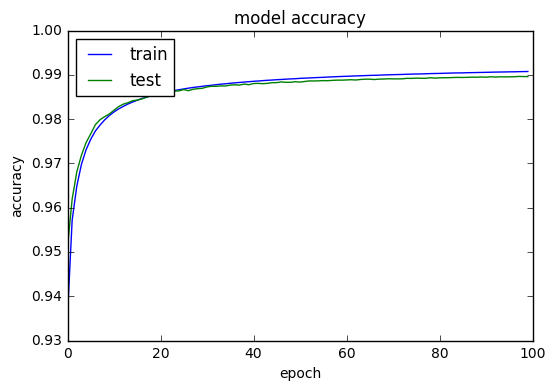

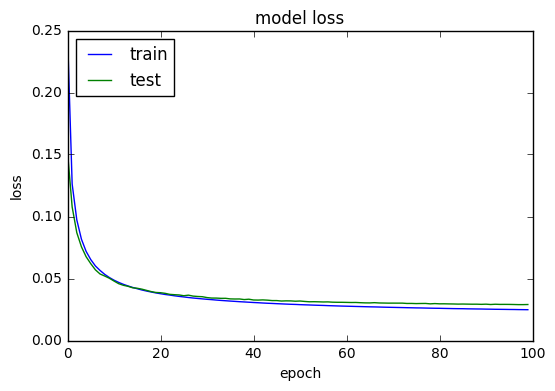

In [16]:
if KINECT == 0:
    # list all data in history
    print(history_.keys())
    # summarize history for accuracy
    plt.plot(history_['acc'])
    plt.plot(history_['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history_['loss'])
    plt.plot(history_['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Model visualization

In [17]:
# plot_model(autoencoder, to_file='model.png', show_shapes=True)

### Load testing data and evaluate score

In [32]:
# if KINECT == 0:
score = autoencoder.evaluate(test_data, test_label, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# score = autoencoder.evaluate(train_data, train_label, verbose=0)
# print('Train score:', score[0])
# print('Train accuracy:', score[1])

22600/22600 [==============================] - 124s   
Test score: 0.0474236826071
Test accuracy: 0.982513470945


### Visualizing results

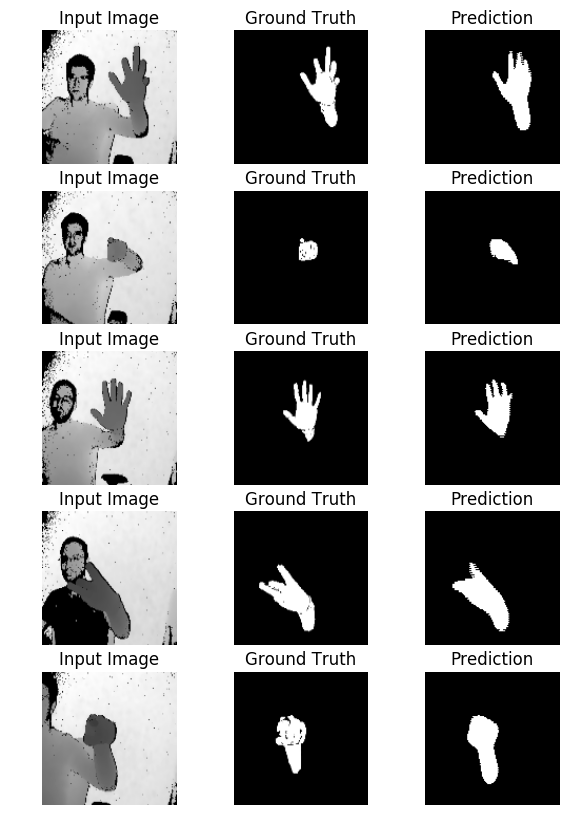

In [60]:
# if KINECT == 0:
testing_indx = np.random.choice(n_test, 5)

test_ite = test_data[testing_indx, :, :, :]
# test_ite = np.expand_dims(test_ite, axis=0)

# # output = autoencoder.predict_proba(test_ite, verbose=1)
# output = autoencoder.predict_classes(test_ite, verbose=1)

# # plot_results_2(output, testing_indx)
# plot_results(output, testing_indx)

output = autoencoder.predict_proba(test_ite, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

plot_results(output, testing_indx)

In [21]:
# test_ite_ = test_ite[0, :, :, 0]
# # test_ite_ = np.rot90(test_ite_, -1)

# # cv2.imshow('depth', test_ite_)

# frame8bit = test_ite_
# # frame8bit = np.flip(frame8bit, 0)
# # frame8bit = np.rot90(frame8bit, -1)
# print(frame8bit)

# cv2.imshow('original image', frame8bit)
# print(frame8bit.shape)

# frame8bit_for_autoencoder = np.resize(frame8bit, (1, 128, 128, 1))

# output = autoencoder.predict_proba(frame8bit_for_autoencoder, verbose=0)
# output = output.reshape((output.shape[0], img_h, img_w, n_labels))

# frame8bit = resize(frame8bit[:, :], (img_h, img_w))

# rgb = np.zeros((img_h, 2*img_w, 3))
# labeled = np.argmax(output[0], axis=-1)

# rgb[:, :img_w, 0] = frame8bit
# rgb[:, :img_w, 1] = frame8bit
# rgb[:, :img_w, 2] = frame8bit

# rgb[:, img_w:, 0] = labeled

# #             rgb = cv2.resize(rgb, (2*256, 213))
# # #             rgb = cv2.resize(rgb, (512, 424))

# pred_time = time.time() - start_time
# print('FPS: ' + str(int(1.0/pred_time)))

# cv2.imshow('hand segmentation', rgb)


# k = cv2.waitKey(0) & 0xff
# if k == 27:     # Esc
#     cv2.destroyAllWindows()

In [22]:
# cv2.destroyAllWindows()

# Realtime visualization

In [23]:
# if KINECT == 0:
#     # test_data, test_label = prep_data('test')

#     if AD_TEST_ONLY == 0:
#         df = pd.read_csv(path + TEST_CSV)
#     else:
#         df = pd.read_csv(path + AD_TEST_CSV)

#     n_test_imgs = 1
#     n_type_outputs = 3

#     for i, item in df.iterrows():
#         clear_output(wait=True)

#         # Call trained model
#         test_ite = test_data[i, :, :, :]
#         test_ite = np.expand_dims(test_ite, axis=0)
#         print(test_ite.shape)
#         start_time = time.time()
#         output = autoencoder.predict_proba(test_ite, verbose=0)
#         pred_time = time.time() - start_time
#         output = output.reshape((output.shape[0], img_h, img_w, n_labels))

#         # Load input image
#         im = resize(imread(path + item[0]), (img_h, img_w))

#         # Load ground truth
#         gt = np.ceil(resize(~(imread(path + item[1])[:, :, 0]), (img_h, img_w))).astype(int)

#     #     rgb = np.empty((img_h, img_w, 3))
#         rgb = np.empty((img_h, 3*img_w, 3))
#         labeled = np.argmax(output[0], axis=-1)
#         img = resize(imread(path + item[0]), (img_h, img_w))
#         rgb[:, :img_w, 0] = img
#         rgb[:, :img_w, 1] = img
#         rgb[:, :img_w, 2] = img

#         rgb[:, img_w:2*img_w, 0] = img
#         rgb[:, img_w:2*img_w, 1] = img
#         rgb[:, img_w:2*img_w, 2] = img + gt

#         rgb[:, 2*img_w:, 0] = img
#         rgb[:, 2*img_w:, 1] = img + labeled
#         rgb[:, 2*img_w:, 2] = img

#         rgb = cv2.resize(rgb, (3*256, 213))

#         cv2.imshow('hand segmentation', rgb)
#         print('FPS: ' + str(int(1.0/pred_time)))

#         k = cv2.waitKey(30) & 0xff
#         if k == 27:     # Esc
#             cv2.destroyAllWindows()
#             break

# Kinect Hand Segmentation

In [24]:
# cv2.destroyAllWindows()
# kinect.close()

In [25]:
# if KINECT == 1:
#     kinect = PyKinectRuntime.PyKinectRuntime(PyKinectV2.FrameSourceTypes_Depth)
    
#     for dir_path, dir_names, file_names in os.walk('E:/fingerpaint_dataset_segnet/data/depth/combinedSubjectA_depth'):
#         for file_name in [f for f in file_names if f.endswith('.png')]:
#             depth_img = os.path.join(dir_path, file_name).replace("\\","/")
            
# #     while True:
# #         if kinect.has_new_depth_frame():
#             clear_output(wait=True)
            
#             start_time = time.time()
            
#             # Getting frames
#             frame = kinect.get_last_color_frame()
# #             frame = kinect.get_last_depth_frame()

#             # Displaying frames
#             # if frame is None:  # some usb hub do not provide the depth image. it works with Kinect studio though
#             #     return
            
# #             print(frame)
#             f8=np.uint8(frame.clip(1,1000)/16.)
# #             f8=np.uint8(frame.clip(1,4000)/16.)
# #             frame8bit_ = frame8bit
# #             frame8bit = np.dstack((frame8bit_, frame8bit_, frame8bit_))
#             frame8bit = np.dstack((f8,f8,f8))
#             frame8bit = np.reshape(frame8bit, (kinect.depth_frame_desc.Height, kinect.depth_frame_desc.Width, 3))
#             frame8bit = frame8bit[:, :, 0]
            
#             frame8bit = imread(depth_img)
            
#             frame8bit = resize(frame8bit, (img_h, img_w))
            
#             frame8bit_for_autoencoder = np.rot90(frame8bit)
#             frame8bit_for_autoencoder = np.flip(frame8bit_for_autoencoder, 0)
            
#             frame8bit_for_autoencoder = np.resize(frame8bit_for_autoencoder, (1, 128, 128, 1))
            
#             output = autoencoder.predict_proba(frame8bit_for_autoencoder, verbose=0)
#             output = output.reshape((output.shape[0], img_h, img_w, n_labels))

#             rgb = np.zeros((img_h, 2*img_w, 3))
#             labeled = np.argmax(output[0], axis=-1)
            
#             rgb[:, :img_w, 0] = frame8bit
#             rgb[:, :img_w, 1] = frame8bit
#             rgb[:, :img_w, 2] = frame8bit
            
#             rgb[:, img_w:, 0] = frame8bit
#             rgb[:, img_w:, 1] = frame8bit + labeled
#             rgb[:, img_w:, 2] = frame8bit

#             rgb = cv2.resize(rgb, (2*256, 213))
# # #             rgb = cv2.resize(rgb, (512, 424))
            
#             pred_time = time.time() - start_time
#             print('FPS: ' + str(int(1.0/pred_time)))
            
#             cv2.imshow('hand segmentation', rgb)

#             k = cv2.waitKey(30) & 0xff
#             if k == 27:     # Esc
#                 # Releasing frames
#                 frame = None
#                 cv2.destroyAllWindows()
#                 kinect.close()
#                 break